# VAE for a single binary pixel

In [1]:
import torch
from torch import nn
import BernoulliDatastream as data
import numpy as np
from torch.utils.data import DataLoader
from AEML import AEML
from VAEBase import VAEBase

`VAENormal` is a base class of all our variational autoencoders. Write your code between the two pairs of `YOUR CODE HERE` comments.

- `VAENormal.forward()` receives an input image `x`, `enc_...()`odes it, etc., and returns the result of `self.dec()`.
- `BernoulliLoss.__call__()` returns the scalar loss associated with the generated Bernoulli parameter array `xz` and the input image `x`.

Both methods actually receive a *batch* of images in the form of a `torch.Tensor` whose first dimension runs over the instances. Except for the computation of the scalar end result of the loss function, your code should hardly have to care; it should mostly read like it receives individual images.

The same solution should work for all exercises.

In [2]:
class VAENormal(VAEBase):
    def __init__(self, enc_mu, enc_logsigma, dec):
        super(VAENormal, self).__init__()
        self.distrib_pz = torch.distributions.Normal(0, 1) # q(z|x), p(z)
        self.enc_mu = enc_mu
        self.enc_logsigma = enc_logsigma
        self.dec = dec

    def forward(self, x):
        x = nn.Flatten()(x)
        ### BEGIN YOUR CODE HERE
        # get latent parameters from encoder
        self.mu = self.enc_mu(x)
        self.logsigma = self.enc_logsigma(x)
        self.sigma = torch.exp(self.logsigma)

        # sample from q(z|x)
        epsilon = torch.randn_like(self.mu)
        z = self.mu + self.sigma * epsilon

        return self.dec(z)
        ### END YOUR CODE HERE

    def encode_mu(self, x):
        return self.enc_mu(nn.Flatten()(x))


class BernoulliLoss: # p(x|z) is Bernoulli; q(z|x) and p(z) are Normal
    def __init__(self, vae):
        self.vae = vae
        self.BCE = nn.BCELoss(reduction='none')

    def __call__(self, xz, x):
        ### BEGIN YOUR CODE HERE
        x = nn.Flatten()(x)
        reconstruction_loss = torch.sum(self.BCE(xz, x), dim=1)  # sum over pixels

        kl_div = 1/2 * torch.sum(self.vae.mu**2 + self.vae.sigma**2 - torch.log(self.vae.sigma**2) - 1, dim=1)
        
        return torch.mean(reconstruction_loss) + torch.mean(kl_div)
        ### END YOUR CODE HERE

This class is derived from `VAENormal` which is in turn derived from `nn.Module` and implements the common parts of a basic VAE neural-network model:

In [3]:
class VAE(VAENormal):
    def __init__(self):
        super(VAE, self).__init__(
            # Normal paramters of q(z|x):
            enc_mu = nn.Linear(1, 1),
            enc_logsigma = nn.Linear(1, 1),
            # Bernoulli parameter of p(x|z):
            dec = nn.Sequential(nn.Linear(1, 1), nn.Sigmoid())
        )
        
    def init(self, p):          # p_Bernoulli
        self.enc_mu.weight       = nn.Parameter(torch.tensor([[1.0]]))
        self.enc_mu.bias         = nn.Parameter(torch.tensor([-0.5]))
        self.enc_logsigma.weight = nn.Parameter(torch.tensor([[0.0]]))
        self.enc_logsigma.bias   = nn.Parameter(torch.log(torch.tensor([0.5])))
        self.dec[0].bias = nn.Parameter(torch.log(torch.tensor([p / (1-p)])))
        self.init_dec_weight()

    def init_dec_weight(self):
        # This weight is the decisive parameter;
        # if it is large enough, the above can be left random:
        self.dec[0].weight = nn.Parameter(torch.tensor([[10.0]]))

    def print_params(this):
        for name, param in this.named_parameters():
            print(f"{name:20s} {param.item():9.6f}")

## Before training, possibly with manually-initialized weights

This implements a loss function that counts mismatching pixels:

In [4]:
class AccuracyLoss:      # not suitable for training, only for testing
    def __init__(self, vae):
        self.vae = vae

    def __call__(self, xz, x):
        # proportion of false reconstructions
        return (torch.abs(xz - x) > 0.5).sum() / len(xz)

Create an autoencoder model **initialized in a given way**, and display its weights:

In [5]:
model = VAE()
p_Bernoulli = 0.5               # play with this
model.init(p_Bernoulli)             # try this
#model.init_dec_weight()     # or this, or neither
model.print_params()
N = 1024

enc_mu.weight         1.000000
enc_mu.bias          -0.500000
enc_logsigma.weight   0.000000
enc_logsigma.bias    -0.693147
dec.0.weight         10.000000
dec.0.bias            0.000000


### Untrained Decoder

This helper function generates Bernoulli output parameters $\textrm{dec}(z)$ by sampling $z \sim p(z)$, and collects them in a histogram:

In [6]:
def generate(model, N):
    vals = np.zeros(N)
    for i in range(N):
        vals[i] = model.sample(1)
    print(np.histogram(vals, range=(0, 1))[0], (vals > 0.5).sum() / N)

Show Bernoulli output parameters first by sampling $z \sim p(z)$ and then by sampling $z$ from a regular grid:

[449  32  24  17  18  20   9  20  37 398] 0.47265625


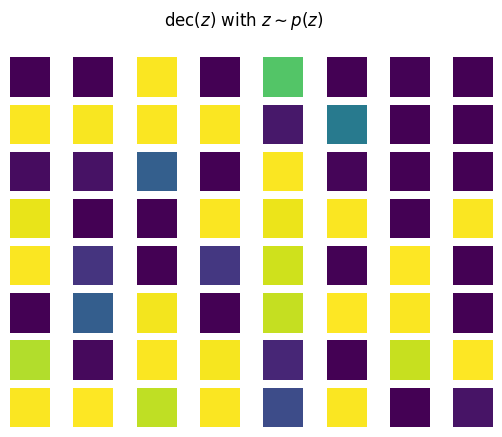

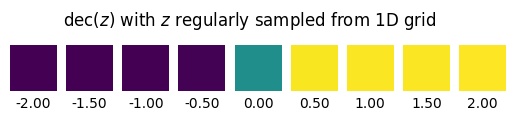

In [7]:
generate(model, N)
model.plotDecRandom(1)
model.plotDecGrid(1)

How can we **sharpen the generator**?

- by moving the means of the $q_{\phi}(z|x)$ further apart
- by tightening the variances of the $q_{\phi}(z|x)$

### Untrained Encoder

Now let's watch our encoder in action. Create an untrainable `AEML` instance to allow us to easily generate data using the `BernoulliDatastream`, encode $N$ generated instances $x_n$, and display the $\textrm{enc}(x_n)$ in 1D $z$ space:

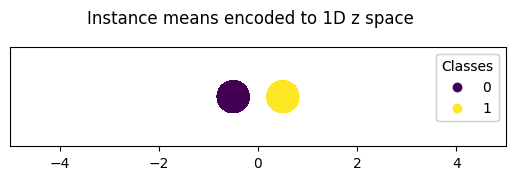

In [8]:
mltest = AEML(DataLoader(data.BernoulliDatastream(p_Bernoulli, N)),
              model, AccuracyLoss(model), None)
mltest.plotEncDataset()

### Untrained round-trip evaluation

Run our model on $N$ test instances and check the proportion of false reconstructions:

In [9]:
print(f"test_loss={mltest.test():.3f}")

test_loss=0.164


## Training

Now instantiate a trainable `AEML` instance for a Bernoulli $p_{\theta}(x|z)$ and an Adam optimizer.

Train it for some epochs, displaying the proportion of false reconstructions on a test run after each epoch:

In [14]:
ml = AEML(DataLoader(data.BernoulliDatastream(p_Bernoulli, 1024),
                     batch_size = 8),
          model,
          BernoulliLoss(model),
          torch.optim.Adam(model.parameters(), lr=1e-3))

n_epochs = 100
for epoch in range(n_epochs):
    final_train_loss = ml.train()
    test_loss = mltest.test()
    print(f"Epoch{epoch:4d} {final_train_loss=:.3f} {test_loss=:.3f}")
model.print_params()

Epoch   0 final_train_loss=0.500 test_loss=0.091
Epoch   1 final_train_loss=0.501 test_loss=0.109
Epoch   2 final_train_loss=0.526 test_loss=0.101
Epoch   3 final_train_loss=0.519 test_loss=0.096
Epoch   4 final_train_loss=0.542 test_loss=0.090
Epoch   5 final_train_loss=1.061 test_loss=0.111
Epoch   6 final_train_loss=0.534 test_loss=0.094
Epoch   7 final_train_loss=0.547 test_loss=0.119
Epoch   8 final_train_loss=0.916 test_loss=0.122
Epoch   9 final_train_loss=0.737 test_loss=0.112
Epoch  10 final_train_loss=0.569 test_loss=0.100
Epoch  11 final_train_loss=0.471 test_loss=0.130
Epoch  12 final_train_loss=0.565 test_loss=0.110
Epoch  13 final_train_loss=0.918 test_loss=0.118
Epoch  14 final_train_loss=0.517 test_loss=0.097
Epoch  15 final_train_loss=0.633 test_loss=0.111
Epoch  16 final_train_loss=0.719 test_loss=0.120
Epoch  17 final_train_loss=0.510 test_loss=0.107
Epoch  18 final_train_loss=1.021 test_loss=0.108
Epoch  19 final_train_loss=0.894 test_loss=0.108
Epoch  20 final_trai

Now visualize again the encoder and decoder, this time of the trained model:

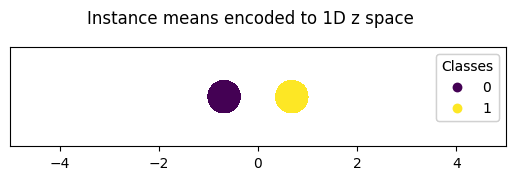

In [15]:
ml.plotEncDataset()

[250 101  89  61  45  37  56  74  82 229] 0.466796875


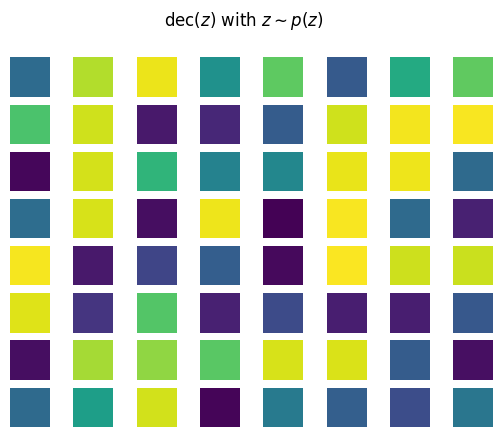

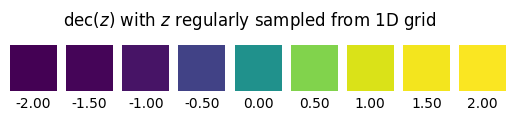

In [16]:
generate(model, N)
model.plotDecRandom(1)
model.plotDecGrid(1)

Show some inputs and corresponding reconstructed outputs:

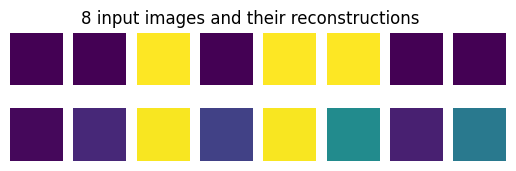

In [17]:
ml.plotReconDataset()

What happens if we **change the population Bernoulli $p$ parameter** away from $1/2$?